In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from yellowbrick.cluster import SilhouetteVisualizer
from gensim.models.fasttext import FastText


import warnings

warnings.filterwarnings('ignore')

d:\Anaconda\envs\DataScience\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\envs\DataScience\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
d:\Anaconda\envs\DataScience\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [11]:
data = pd.read_csv("../data/keyword_jptiik.csv")

data_abs = data[["abstract"]]
data_abs.head()

,abstract
0,teknologi mixed reality akan membuat interaksi...
1,penjadwalan merupakan salah satu proses pentin...
2,untuk memenuhi kebutuhan masyarakat akan keter...
3,perusahaan mcdonald’s adalah perusahaan yang b...
4,perkembangan internet saat ini sangat pesat. d...


In [12]:
data_abs["abstract"] = data_abs["abstract"].str.strip()
data_abs["abstract"] = data_abs["abstract"].str.lower()
data_abs["abstract"] = data_abs["abstract"].str.replace('[^\w\s]','')
data_abs["abstract"] = data_abs["abstract"].str.replace('\d+', '')
data_abs["abstract"] = data_abs["abstract"].str.replace('\s+', ' ')
data_abs["abstract"] = data_abs["abstract"].str.replace('\n', ' ')
data_abs["abstract"] = data_abs["abstract"].str.replace('\t', ' ')
data_abs["abstract"] = data_abs["abstract"].str.replace('  ', ' ')

In [14]:
stopword = StopWordRemoverFactory().create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()

data_abs["abstract"] = data_abs["abstract"].apply(lambda x: stopword.remove(x))
data_abs["abstract"] = data_abs["abstract"].apply(lambda x: stemmer.stem(x))

In [8]:
cores = multiprocessing.cpu_count()
embed_model = FastText.load_fasttext_format("../data/id/id.bin")

In [23]:
all(embed_model.wv["saya"] == embed_model.wv["saya"])


True

In [24]:
data_embed = data_abs["abstract"].apply(lambda x: embed_model.wv[x])

In [31]:
data_embed_np = np.array([np.array(x) for x in data_embed])

(3479, 300)

In [34]:
data_torch = torch.from_numpy(data_embed_np).float()
data_torch.shape

torch.Size([300])

In [36]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(300, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 25)
        # self.fc5 = nn.Linear(8, 4)
        # self.fc6 = nn.Linear(4, 2)
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()

    
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.fc3(x)
        x = self.gelu(x)
        x = self.fc4(x)
        # x = self.gelu(x)
        # x = self.fc5(x)
        # x = self.gelu(x)
        # x = self.fc6(x)

        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.fc6 = nn.Linear(2, 4)
        # self.fc5 = nn.Linear(4, 8)
        self.fc4 = nn.Linear(25, 50)
        self.fc3 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 200)
        self.fc1 = nn.Linear(200, 300)
        # self.like_embedding = nn.Linear(109, 109)
        # self.embedding = nn.Embedding(109, VOCAB_SIZE) # I'm not sure..
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.selu = nn.SELU()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x = self.fc6(x)
        # x = self.gelu(x)
        # x = self.fc5(x)
        # x = self.gelu(x)
        x = self.fc4(x)
        x = self.gelu(x)
        x = self.fc3(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.fc1(x)
        # x = self.like_embedding(x)
        # x = x.type(torch.LongTensor)
        # x = self.embedding(x)

        return x

class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [43]:
E = Encoder()
D = Decoder()

E(data_torch[0]).shape

torch.Size([25])

In [50]:
(data_torch == D(E(data_torch))).sum()

tensor(0)

In [40]:
D(E(data_torch[0])).shape

torch.Size([300])

In [119]:
E = Encoder()
D = Decoder()
AE = AutoEncoder(E, D)

loss_log = []
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(AE.parameters(), lr=0.01)

for epoch in range(200):
    
    optimizer.zero_grad()
    output = AE(data_torch)
    loss = criterion(output, data_torch)
    loss.backward()
    optimizer.step()
    loss_log.append(loss.item())
    print(loss)

tensor(0.0024, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0010, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0005, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0006, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0008, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0005, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0005, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0004, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0005, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0004, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0004, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0004, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0004, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0004, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0005, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0006, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0004, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0005, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0004, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0004, grad_fn=<SmoothL1LossBackward0>)
tensor(0.0004, grad_fn=<SmoothL1LossBack

kayaknya masih ada yang salah.. kita gak bisa mengoreksi bobot embeddingnya.. kita cuma menyamakan embedding input dan output. Jadinya ga ke update. Kayaknya ini waktunya pake embedding yang udah ke pretrained.

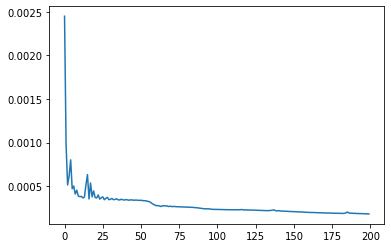

In [120]:
plt.plot(loss_log)

In [121]:
latent_representation = AE.encoder(data_torch)
latent_representation.shape     

torch.Size([3479, 25])

In [122]:
# to dataframe
latent_df = pd.DataFrame(latent_representation.detach().numpy())
latent_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.154274,0.142792,-0.390894,0.105268,0.114790,0.146392,-0.042706,-0.207239,0.011502,0.046033,...,-0.215588,-0.203910,0.013987,-0.132741,0.048248,0.037712,0.129732,0.147881,0.021399,0.027291
1,0.022866,0.076076,-0.211264,0.200354,0.057924,0.144790,-0.142762,-0.129975,0.003727,0.037166,...,-0.118324,0.045435,-0.069044,-0.096983,-0.017237,0.145996,0.115238,0.047725,0.081277,0.161628
2,-0.132599,0.183274,-0.457608,0.137380,0.131649,0.112604,-0.114708,-0.268711,0.071458,0.053559,...,-0.191087,-0.271093,-0.024036,-0.097089,0.077125,0.043963,0.129000,0.179778,0.063817,-0.041515
3,0.035133,0.032951,-0.174266,0.129945,0.029347,0.066690,-0.093421,-0.040550,0.042855,-0.002357,...,-0.040163,0.055328,-0.079000,-0.017186,0.052036,0.091194,0.079926,0.034398,0.036963,0.107177
4,-0.102708,0.166290,-0.443609,0.107537,0.118660,0.050031,-0.114468,-0.229271,0.112504,0.034764,...,-0.128556,-0.275807,-0.042166,-0.032388,0.135116,0.025752,0.104615,0.190791,0.074070,-0.084334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,-0.062345,0.097719,-0.292390,0.129693,0.079910,0.130818,-0.071498,-0.151870,0.023801,0.037145,...,-0.137902,-0.085243,-0.025409,-0.090040,0.032554,0.076122,0.118346,0.103670,0.038297,0.077385
3475,-0.071990,0.116144,-0.299658,0.170528,0.091671,0.135334,-0.095892,-0.169002,0.021958,0.028572,...,-0.165640,-0.082835,-0.039217,-0.114985,0.022279,0.089106,0.125388,0.088191,0.038029,0.080453
3476,0.118226,-0.158748,-0.105856,-0.253738,-0.024075,0.002476,0.155923,0.127946,0.093805,-0.060844,...,0.190369,0.029217,0.054080,0.193649,0.157964,-0.053071,-0.086651,0.006331,-0.097998,0.030534
3477,0.014432,0.018083,-0.247011,-0.034850,0.061877,-0.073703,-0.015627,-0.024905,0.177214,-0.075681,...,0.072027,-0.155419,-0.038426,0.132388,0.235162,-0.023083,-0.014711,0.111855,-0.010851,-0.123617


In [123]:
JUMLAH_PEMINATAN = 6
k_means = KMeans(n_clusters=JUMLAH_PEMINATAN).fit(latent_representation.detach().numpy())
labels = k_means.labels_

In [124]:
data["labels"] = labels

In [125]:
data["labels"].value_counts()

0    1669
4    1634
1      74
2      41
3      33
5      28
Name: labels, dtype: int64

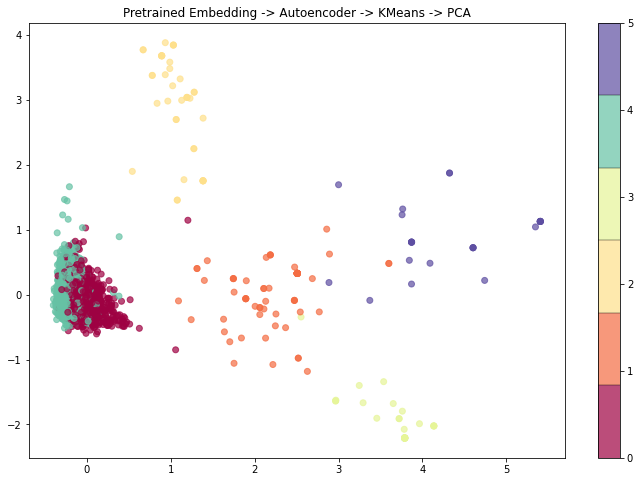

In [127]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_representation.detach().numpy())
plt.figure(figsize=(12,8))
cmap = plt.cm.get_cmap('Spectral', 6)
plt.title("Pretrained Embedding -> Autoencoder -> KMeans -> PCA")
plt.scatter(pca_result[:,0], pca_result[:,1], c=labels, cmap=cmap, alpha=0.7)
plt.colorbar(drawedges=True)
plt.show()

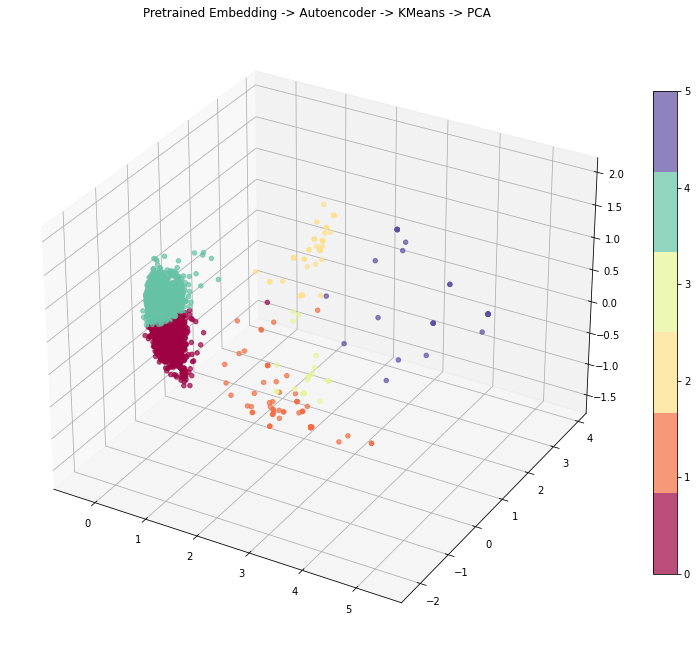

In [129]:
pca = PCA(n_components=3)
pca_result_3 = pca.fit_transform(latent_representation.detach().numpy())
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.set_title("Pretrained Embedding -> Autoencoder -> KMeans -> PCA")
sp = ax.scatter(pca_result_3[:,0], pca_result_3[:,1], pca_result_3[:,2], c=labels, cmap=cmap, alpha=0.7)
fig.colorbar(sp, fraction=0.036, pad=0.04)

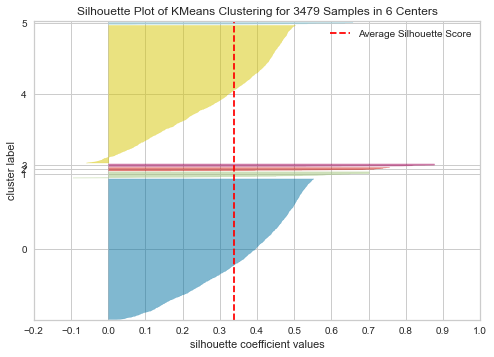

0.33787456

In [138]:
visualizer = SilhouetteVisualizer(k_means, colors='yellowbrick')
visualizer.fit(latent_representation.detach().numpy()) 
visualizer.show()  

silhouette_score(latent_representation.detach().numpy(), labels)

In [ ]:
DATA_NAME = "../data/cluster_poc pretrained embed_jptiik.csv"
MODEL_NAME = "../model/full_ae_poc pretrained embed_jptiik.pt"

data.to_csv(DATA_NAME, index=False)
torch.save(AE, MODEL_NAME)
